# Google Brain - Ventilator Pressure Prediction

In [1]:
# Installing the modules

!pip3 install kaggle

In [2]:

# Required modules

import numpy as np
import pandas as pd
import seaborn as sns

from zipfile import ZipFile
from google.colab import files
from matplotlib import pyplot as plt

from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveRegressor

In [3]:
# Config

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 12)

In [4]:
# Upload the creds

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anurag1817","key":"fee9a6f9d27c73cdef9835b97335e533"}'}

In [5]:
# Create kaggle folder

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Test the command

!kaggle competitions download -c ventilator-pressure-prediction

 74% 56.0M/75.4M [00:00<00:00, 118MB/s]
100% 75.4M/75.4M [00:00<00:00, 140MB/s]
  0% 0.00/8.50M [00:00<?, ?B/s]
100% 8.50M/8.50M [00:00<00:00, 132MB/s]
 98% 137M/139M [00:00<00:00, 157MB/s]
100% 139M/139M [00:01<00:00, 142MB/s]


In [7]:
# Opening the zipfile

with ZipFile('train.csv.zip', 'r') as zf:
    zf.extractall('./')

with ZipFile('test.csv.zip', 'r') as zf:
    zf.extractall('./')

with ZipFile('sample_submission.csv.zip', 'r') as zf:
    zf.extractall('./')

In [8]:
# Load the train data

train = pd.read_csv('train.csv', index_col=['id'])
train.head()

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


breath_id   R   C  time_step       u_in  u_out   pressure
id                                                           
1           1  20  50   0.000000   0.083334      0   5.837492
2           1  20  50   0.033652  18.383041      0   5.907794
3           1  20  50   0.067514  22.509278      0   7.876254
4           1  20  50   0.101542  22.808822      0  11.742872
5           1  20  50   0.135756  25.355850      0  12.234987

In [9]:
# Inspecting the train data

train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6036000 entries, 1 to 6036000
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   breath_id  int64  
 1   R          int64  
 2   C          int64  
 3   time_step  float64
 4   u_in       float64
 5   u_out      int64  
 6   pressure   float64
dtypes: float64(3), int64(4)
memory usage: 368.4 MB


breath_id             R  ...         u_out      pressure
count  6.036000e+06  6.036000e+06  ...  6.036000e+06  6.036000e+06
mean   6.283886e+04  2.703618e+01  ...  6.204493e-01  1.122041e+01
std    3.633526e+04  1.959549e+01  ...  4.852752e-01  8.109703e+00
min    1.000000e+00  5.000000e+00  ...  0.000000e+00 -1.895744e+00
25%    3.137700e+04  5.000000e+00  ...  0.000000e+00  6.329607e+00
50%    6.276550e+04  2.000000e+01  ...  1.000000e+00  7.032628e+00
75%    9.430100e+04  5.000000e+01  ...  1.000000e+00  1.364103e+01
max    1.257490e+05  5.000000e+01  ...  1.000000e+00  6.482099e+01

[8 rows x 7 columns]

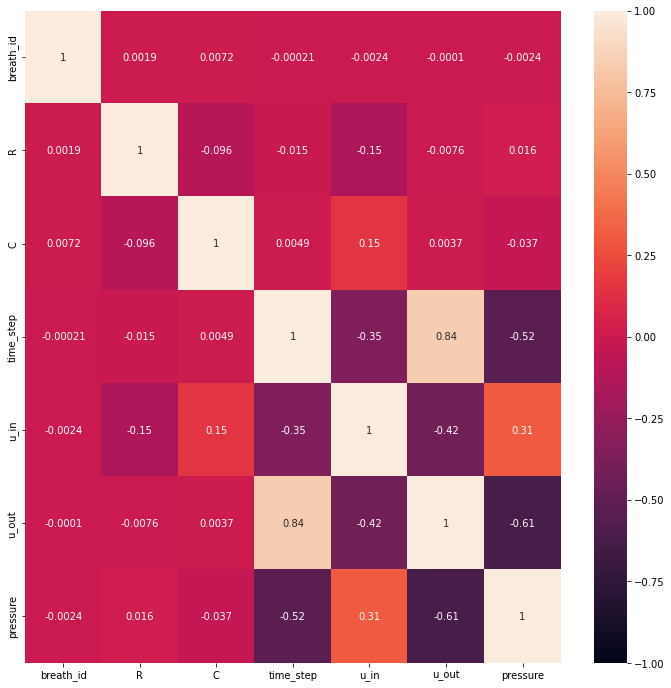

In [10]:
# Correlation matrix

sns.heatmap(train.corr(), annot=True, vmin=-1, vmax=1)

In [11]:
# Missing values

if train.isna().any().any():
    print(train.isna().sum()/train.shape[0])
else:
    print("No Mising values")

No Mising values


In [12]:
# Seperating out features and labels

X = train.drop(['pressure', 'breath_id'], axis=1)
y = train['pressure']

In [13]:
# Train and Test split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [28]:
# Fit a LGBM Classifier

model = LGBMRegressor(n_estimators=500, verbose=2, n_jobs=-1)
model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
              verbose=2)

In [29]:
# Evaluting the model(on train)

model.score(X_train, y_train)

0.7648549363599497

In [30]:
# Evaluting the model(on valid)

model.score(X_valid, y_valid)

0.7654707786979613

In [31]:
# Loading the test set

test = pd.read_csv('test.csv', index_col=['id'])
test.head()

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


breath_id  R   C  time_step       u_in  u_out
id                                               
1           0  5  20   0.000000   0.000000      0
2           0  5  20   0.031904   7.515046      0
3           0  5  20   0.063827  14.651675      0
4           0  5  20   0.095751  21.230610      0
5           0  5  20   0.127644  26.320956      0

In [32]:
# Prediction on test set

test_pred = model.predict(test.drop('breath_id', axis=1))

In [33]:
# Submission

submission = pd.read_csv('sample_submission.csv')
submission['pressure'] = test_pred
submission.to_csv('output.csv', index=False)

In [34]:
# Kaggle Submission

!kaggle competitions submit -c ventilator-pressure-prediction -f output.csv -m "LGBM 500"

100% 99.6M/99.6M [00:03<00:00, 32.3MB/s]
Successfully submitted to Google Brain - Ventilator Pressure Prediction